In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# for number crunching
import numpy as np
import scipy.stats as stats
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns

# Extre libraries
from datetime import datetime

/kaggle/input/online-retail-ii-uci/online_retail_II.csv


In [2]:
os.listdir('/kaggle/input/online-retail-ii-uci')

['online_retail_II.csv']

In [3]:
data = pd.read_csv('/kaggle/input/online-retail-ii-uci/online_retail_II.csv')

data.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


# Creating necessary columns

In [4]:
# Making sure Date is in datetime format
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Total ammount column
data['TotalAmount'] = data['Price'] * data['Quantity']

data.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalAmount
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [5]:
# Deleting all rows with null values
data = data.dropna(subset = ['Customer ID'])

# Eliminating rows with negative quantities

# Note: don't eliminate this data, TO BE DETERMINED

data = data[data['Quantity'] >= 0]

data = data[data['Price'] >= 0]

In [6]:
# Making lists with Customers with heavily outlying behavior
OutlierCustomersPrice = data[data['Price'] > data['Price'].quantile(0.9995)]['Customer ID'].unique()
OutlierCustomersQuantity = data[data['Quantity'] > data['Quantity'].quantile(0.9995)]['Customer ID'].unique()

# Combinning the lists
outlierCustomers = np.union1d(OutlierCustomersPrice, OutlierCustomersQuantity)

# Excluding outliers from data
data = data[~data['Customer ID'].isin(outlierCustomers)]

In [7]:
# Validating null values again
data.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
TotalAmount    0
dtype: int64

In [8]:
# Validating negative values again
(data[['Price', 'Quantity', 'TotalAmount']] < 0).sum()

Price          0
Quantity       0
TotalAmount    0
dtype: int64

# Data Cleaning

In [9]:
# We'll only work with transactions from the UK

# Keeping only transactions made in the UK
data = data[data['Country'] == 'United Kingdom']

In [10]:
print(data['Country'].describe())

count             654357
unique                 1
top       United Kingdom
freq              654357
Name: Country, dtype: object


# Data division between present and future

In [11]:
futureMax = data['InvoiceDate'].max()

print(futureMax)

2011-12-09 12:49:00


In [12]:
# Data delimitation (three months before)
presentvalue = pd.Timestamp('2011-09-01')

print(presentvalue)

2011-09-01 00:00:00


In [13]:
# Dividing data between present and future
futureData = data[(data['InvoiceDate'] > presentvalue) & (data['InvoiceDate'] <= presentvalue + pd.DateOffset(months=3))]

data = data[data['InvoiceDate'] <= presentvalue]

# Creating Customer Dataset

In [14]:
# Calculating the "present day" for metrics like Recency
presentDay = presentvalue

# Calculate date metrics
firstPurchase = data.groupby('Customer ID')['InvoiceDate'].min()
lastPurchase = data.groupby('Customer ID')['InvoiceDate'].max()

# Calculate customer lifespan metrics
# We don't want 0 in active days. First day counts as 1.
activeDays = (lastPurchase - firstPurchase).dt.days + 1

# Recency calculation (Days since last purchase)
recency = (presentDay - lastPurchase).dt.days

activeYears = activeDays / 365.25
activeMonths = activeDays / 30.44

# A stabilization for active months so FrequencyPerMonth doesn't give
# new customer extreme values
activeMonthsSafe = np.maximum(activeMonths, 1)

# Last 30 days
last_30d = data[data['InvoiceDate'] > presentDay - pd.DateOffset(days=30)]
last_30d_spending = last_30d.groupby('Customer ID')['TotalAmount'].sum()
last_30d_frequency = last_30d.groupby('Customer ID')['Invoice'].nunique()

# Last 60 days
last_60d = data[data['InvoiceDate'] > presentDay - pd.DateOffset(days=60)]
last_60d_spending = last_60d.groupby('Customer ID')['TotalAmount'].sum()
last_60d_frequency = last_60d.groupby('Customer ID')['Invoice'].nunique()

# Last 90 days
last_90d = data[data['InvoiceDate'] > presentDay - pd.DateOffset(days=90)]
last_90d_spending = last_90d.groupby('Customer ID')['TotalAmount'].sum()
last_90d_frequency = last_90d.groupby('Customer ID')['Invoice'].nunique()

# Frequency calculation
purchaseFrequency = data.groupby('Customer ID')['Invoice'].nunique()

# Monetary for calculations
monetary = data.groupby('Customer ID')['TotalAmount'].sum()

# Quantity calculation (calculating the total quantity per invoice)
invoiceQuantity = data.groupby(['Customer ID','Invoice'])['Quantity'].sum().reset_index()
avgQuantityPerInvoice = invoiceQuantity.groupby('Customer ID')['Quantity'].mean()

customerData = data.groupby('Customer ID').agg(

    # Monetary (Total Amount of purchases)
    Monetary = ('TotalAmount', 'sum'),
    
    # Average item Price
    #AvgPrice = ('Price', 'mean'), 
    
    # How many unique products bought
    ProductDiversity = ('StockCode', 'nunique')
)

# Recency calculation (Days since last purchase)
customerData['Recency'] = recency

# Frequency calculation
customerData['Frequency'] = purchaseFrequency

# Average order value calculation
customerData['AvgInvoiceValue'] = monetary / purchaseFrequency

# Average Quantity table merge
customerData['AvgQuantityPerInvoice'] = avgQuantityPerInvoice

# Active days
customerData['ActiveDays'] = activeDays

# Average item price
AvgPrice = data.groupby('Customer ID').apply(lambda x: x['TotalAmount'].sum() / x['Quantity'].sum())

# Spending in different time windows
customerData['Spending_Last30d'] = last_30d_spending
customerData['Spending_Last60d'] = last_60d_spending
customerData['Spending_Last90d'] = last_90d_spending

# Frequency in different time windows
customerData['Frequency_Last30d'] = last_30d_frequency
customerData['Frequency_Last60d'] = last_60d_frequency
customerData['Frequency_Last90d'] = last_90d_frequency

# Fill NaN values with 0 for customers with no activity in recent windows
temporal_cols = ['Spending_Last30d', 'Spending_Last60d', 'Spending_Last90d',
                 'Frequency_Last30d', 'Frequency_Last60d', 'Frequency_Last90d']

customerData[temporal_cols] = customerData[temporal_cols].fillna(0)

# Frequency per month
customerData['FrequencyPerMonth'] = purchaseFrequency / activeMonthsSafe

# Calculation of future CLV (spending in the next Quarter), which will be the target
futureCLV = futureData.groupby('Customer ID')['TotalAmount'].sum().rename('FutureCLV')
finalDataset = customerData.merge(futureCLV, how = 'left', left_index = True, right_index = True)
# Filling customers with no spending with a 0 value
finalDataset['FutureCLV'] = finalDataset['FutureCLV'].fillna(0)

finalDataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4574 entries, 12608.0 to 18287.0
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Monetary               4574 non-null   float64
 1   ProductDiversity       4574 non-null   int64  
 2   Recency                4574 non-null   int64  
 3   Frequency              4574 non-null   int64  
 4   AvgInvoiceValue        4574 non-null   float64
 5   AvgQuantityPerInvoice  4574 non-null   float64
 6   ActiveDays             4574 non-null   int64  
 7   Spending_Last30d       4574 non-null   float64
 8   Spending_Last60d       4574 non-null   float64
 9   Spending_Last90d       4574 non-null   float64
 10  Frequency_Last30d      4574 non-null   float64
 11  Frequency_Last60d      4574 non-null   float64
 12  Frequency_Last90d      4574 non-null   float64
 13  FrequencyPerMonth      4574 non-null   float64
 14  FutureCLV              4574 non-null   float64
dtype

/tmp/ipykernel_55/2879707489.py:75: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  AvgPrice = data.groupby('Customer ID').apply(lambda x: x['TotalAmount'].sum() / x['Quantity'].sum())


In [15]:
# Saving a clean copy of the final dataset before cleaning it
rawCustomerDataset = finalDataset.copy()

# Binarizing FutureCLV

In [16]:
threshold = finalDataset['FutureCLV'].quantile(0.85)

finalDataset['BoolFutureCLV'] = (finalDataset['FutureCLV'] >= threshold).astype(int)

In [17]:
finalDataset = finalDataset.drop(columns =['FutureCLV'])

In [18]:
finalDataset['BoolFutureCLV'].value_counts()
finalDataset['BoolFutureCLV'].value_counts(normalize=True)

BoolFutureCLV
0    0.850022
1    0.149978
Name: proportion, dtype: float64

# Client segmentation (Excluding clients with outlying purchase patters)

<Axes: xlabel='Monetary', ylabel='Percent'>

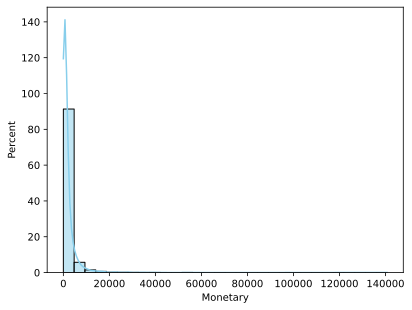

In [19]:
sns.histplot(finalDataset['Monetary'],bins=30, kde=True, color="skyblue", stat="percent")

In [20]:
print(finalDataset['Monetary'].describe())

count      4574.000000
mean       1907.339452
std        4862.633444
min           0.000000
25%         307.355000
50%         723.990000
75%        1857.310000
max      140716.640000
Name: Monetary, dtype: float64


<Axes: xlabel='AvgInvoiceValue', ylabel='Percent'>

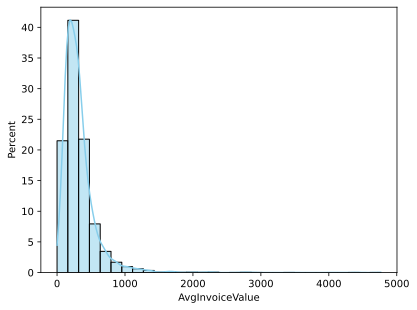

In [21]:
sns.histplot(finalDataset['AvgInvoiceValue'],bins=30, kde=True, color="skyblue", stat="percent")

In [22]:
print(finalDataset['AvgInvoiceValue'].describe())

count    4574.000000
mean      321.689670
std       260.997402
min         0.000000
25%       170.462500
50%       268.315833
75%       388.537500
max      4765.040000
Name: AvgInvoiceValue, dtype: float64


<Axes: xlabel='AvgQuantityPerInvoice', ylabel='Percent'>

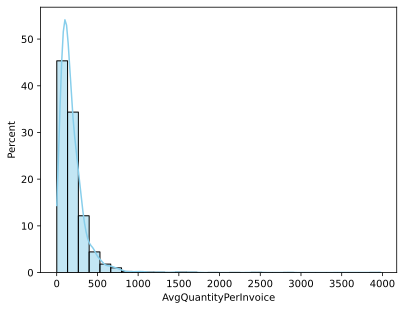

In [23]:
sns.histplot(finalDataset['AvgQuantityPerInvoice'],bins=30, kde=True, color="skyblue", stat="percent")

In [24]:
print(finalDataset['AvgQuantityPerInvoice'].describe())

count    4574.000000
mean      189.125637
std       182.028409
min         1.000000
25%        86.270833
50%       144.171429
75%       238.598039
max      3976.875000
Name: AvgQuantityPerInvoice, dtype: float64


<Axes: xlabel='FrequencyPerMonth', ylabel='Percent'>

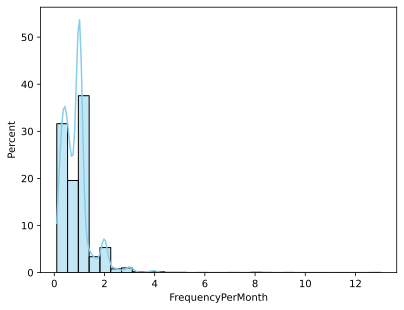

In [25]:
sns.histplot(finalDataset['FrequencyPerMonth'],bins=30, kde=True, color="skyblue", stat="percent")

In [26]:
print(finalDataset['FrequencyPerMonth'].describe())

count    4574.000000
mean        0.882221
std         0.649248
min         0.099477
25%         0.454328
50%         0.908657
75%         1.000000
max        12.997796
Name: FrequencyPerMonth, dtype: float64


<Axes: xlabel='Frequency', ylabel='Percent'>

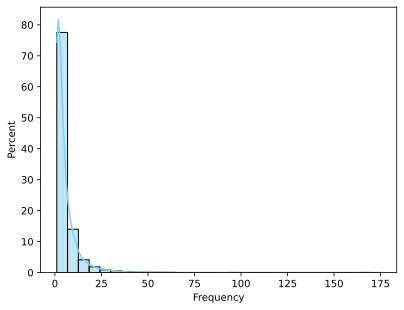

In [27]:
sns.histplot(finalDataset['Frequency'],bins=30, kde=True, color="skyblue", stat="percent")

In [28]:
print(finalDataset['Frequency'].describe())

count    4574.00000
mean        5.20857
std         8.71924
min         1.00000
25%         1.00000
50%         3.00000
75%         6.00000
max       175.00000
Name: Frequency, dtype: float64


# Data normalization, split and coversion into tensors

In [29]:
modelData = finalDataset.copy()

In [30]:
# Separating features from target
X = modelData.drop(columns=['BoolFutureCLV'])
y = modelData['BoolFutureCLV']

# 80 / 20 split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

print(X_train.shape, X_val.shape)

(3887, 14) (687, 14)


In [31]:
# log1p
X_train_log = np.log1p(X_train)
X_val_log   = np.log1p(X_val)

In [32]:
# Robust Scaler

# Initialize scaler
scaler = RobustScaler()

# Fit only for train data
scaler.fit(X_train_log)

RobustScaler()

In [33]:
X_train_scaled = scaler.transform(X_train_log)
X_val_scaled = scaler.transform(X_val_log)

In [34]:
# Pandas dataframe to tensor conversion
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_t = torch.tensor(X_val_scaled, dtype=torch.float32)

y_train_t = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_val_t = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)

In [35]:
batchSize = 32

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds   = TensorDataset(X_val_t,   y_val_t)

train_loader = DataLoader(train_ds, batch_size=batchSize, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batchSize, shuffle=False)

In [36]:
print(X_train_t.shape)
print(X_val_t.shape)

torch.Size([3887, 14])
torch.Size([687, 14])


# Creating and trainning the FFNN

In [37]:
# Creating a class for the model without batchnorm
class FFNN(nn.Module):
    def __init__(self, input_size=14, dropout=0.3):
        super().__init__()
        
        # input layer
        self.input = nn.Linear(input_size, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout(dropout)
        
        # hidden layer 1
        self.fc1 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.dropout2 = nn.Dropout(dropout)
        
        # hidden layer 2
        self.fc2 = nn.Linear(32, 16)
        self.bn3 = nn.BatchNorm1d(16)
        self.dropout3 = nn.Dropout(dropout)
        
        # output layer
        self.output = nn.Linear(16, 1)
    
    def forward(self, x):
        # input layer
        x = self.input(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        
        # hidden layer 1
        x = self.fc1(x)   
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        
        # hidden layer 2
        x = self.fc2(x)        
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout3(x)
        
        # output layer
        return self.output(x)

In [38]:
# grab an instance of the model class
model = FFNN()

# loss function
lossfun = nn.BCEWithLogitsLoss()

# optimizer with L2 Regularization 
optimizer = torch.optim.AdamW(model.parameters(),lr= 0.001,weight_decay=0.0001)

# Scheduler for learning rate decay
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,     # reduce LR by half
    patience=15,     # wait 15 epochs with no improvement
    min_lr = 0.000001
)

In [39]:
# train the model

# Evaluation function
def evaluateModel(model, loader):
    model.eval()

    probs = []
    trues = []

    with torch.no_grad():
        for X, y in loader:
            logits = model(X)
            prob = torch.sigmoid(logits)

            probs.append(prob.cpu().numpy())
            trues.append(y.cpu().numpy())

    probs = np.vstack(probs).ravel()
    trues = np.vstack(trues).ravel()

    preds = (probs >= 0.5).astype(int)

    return {
        "accuracy": accuracy_score(trues, preds),
        "precision": precision_score(trues, preds, zero_division=0),
        "recall": recall_score(trues, preds, zero_division=0),
        "f1": f1_score(trues, preds, zero_division=0),
        "roc_auc": roc_auc_score(trues, probs)
    }

# Epochs
numepochs = 100

def trainTheModel():

    # initialize losses as empties
    trainLosses = []
    valLosses = []
    
    # loop over epochs
    for epoch in range(numepochs):
    
        # Toggle train mode
        model.train()
        batchLoss = []
          
        # initialize batchAcc and batchLoss
        batchAcc  = []
        batchLoss = []
        
        for X,y in train_loader:
          # Clear old gradients  
          optimizer.zero_grad()  
        
          # forward pass and loss
          yhat = model(X)
          loss = lossfun(yhat,y)
        
          # backprop
          loss.backward()
          optimizer.step()
        
          # Append batch Loss
          batchLoss.append( loss.item())
          
        # Average trainning loss for this epoch
        trainLoss = np.mean(batchLoss)
        trainLosses.append(trainLoss)

        # Turning on validation mode
        model.eval()
        with torch.no_grad():
            valLossBatch = []

            for Xv, yv in val_loader:
                yhatv = model(Xv)
                valLossBatch.append(lossfun(yhatv, yv).item())

        valLoss = np.mean(valLossBatch)
        valLosses.append(valLoss)

        # Metrics
        metrics = evaluateModel(model, val_loader)
            
        # Scheduler
        scheduler.step(valLoss)

        # Progress print
        print(
            f"Epoch {epoch:03d} | "
            f"TrainLoss: {trainLoss:.4f} | "
            f"ValLoss: {valLoss:.4f} | "
            f"Recall: {metrics['recall']:.3f} | "
            f"Precision: {metrics['precision']:.3f} | "
            f"ROC-AUC: {metrics['roc_auc']:.3f}"
        )
    
    # function output
    return trainLosses, valLosses

In [40]:
# Train the model
trainLosses, valLosses = trainTheModel()

Epoch 000 | TrainLoss: 0.6022 | ValLoss: 0.5104 | Recall: 0.588 | Precision: 0.400 | ROC-AUC: 0.827
Epoch 001 | TrainLoss: 0.4187 | ValLoss: 0.3697 | Recall: 0.422 | Precision: 0.597 | ROC-AUC: 0.833
Epoch 002 | TrainLoss: 0.3432 | ValLoss: 0.3221 | Recall: 0.422 | Precision: 0.623 | ROC-AUC: 0.851
Epoch 003 | TrainLoss: 0.3354 | ValLoss: 0.3169 | Recall: 0.422 | Precision: 0.573 | ROC-AUC: 0.850
Epoch 004 | TrainLoss: 0.3182 | ValLoss: 0.3099 | Recall: 0.412 | Precision: 0.646 | ROC-AUC: 0.849
Epoch 005 | TrainLoss: 0.3241 | ValLoss: 0.3039 | Recall: 0.382 | Precision: 0.661 | ROC-AUC: 0.852
Epoch 006 | TrainLoss: 0.3138 | ValLoss: 0.3050 | Recall: 0.412 | Precision: 0.627 | ROC-AUC: 0.854
Epoch 007 | TrainLoss: 0.3073 | ValLoss: 0.3033 | Recall: 0.441 | Precision: 0.652 | ROC-AUC: 0.851
Epoch 008 | TrainLoss: 0.3136 | ValLoss: 0.2990 | Recall: 0.373 | Precision: 0.691 | ROC-AUC: 0.857
Epoch 009 | TrainLoss: 0.3104 | ValLoss: 0.3023 | Recall: 0.441 | Precision: 0.652 | ROC-AUC: 0.854


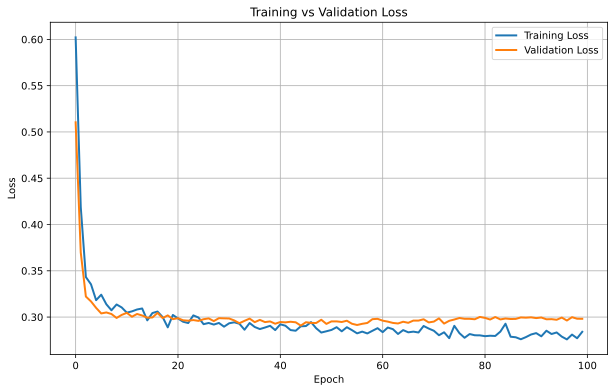

In [41]:
plt.figure(figsize=(10,6))

plt.plot(trainLosses, label='Training Loss', linewidth=2)
plt.plot(valLosses, label='Validation Loss', linewidth=2)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [43]:
# Saving the model as .pt file
torch.save(model.state_dict(), 'Clasification_model.pt')